# Youtube Data EDA

## Project Description

**Goal:** practice EDA

**Context:** YouTube (the world-famous video sharing website) maintains a list of the top trending videos on the platform. According to Variety magazine, “To determine the year’s top-trending videos, YouTube uses a combination of factors including measuring users interactions (number of views, shares, comments and likes). Note that they’re not the most-viewed videos overall for the calendar year”. Top performers on the YouTube trending list are music videos (such as the famously virile “Gangam Style”), celebrity and/or reality TV performances, and the random dude-with-a-camera viral videos that YouTube is well-known for.

This dataset is a daily record of the top trending YouTube videos.

Note that this dataset is a structurally improved version of this dataset.

**Data Source:** https://www.kaggle.com/datasnaek/youtube-new

**Author:** https://www.kaggle.com/datasnaek

_______________

**Data cleaning and exploration notes:**



- Merge 10 csv files into an `all_df` pandas DataFrame
    - utf-8 default results in Error    
    `#UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc3 in position 130670: invalid continuation byte`
    - Solve encoding issues for MX, RU, JP, KR by opening the csv files in an editor, make a small change, save.
    - Regular utf-8 encoding should work now
- Create `country` column
- Drop duplicates & Reset index
- Make `country` , `category_id` columns a categorical dtype
- Turn into datetime `trending_date`, `publish_time`
- Make `views`, `likes`, `dislikes`, `comment_count`,   as np.int32
- Process `video_id`
    - About 2100 rows have a `video_id` equal to `#NAME?` (probaly beacause they all start with a `-`).
    - A few more have `#VALUE!`. 
    - We can extract the correct id value from the `thumbnail_link` URL
- Lowercase `title`, `channel_title`,  `tags`, `description`
- Enrich with [`category`](https://gist.githubusercontent.com/dgp/1b24bf2961521bd75d6c/raw/9abca29c436218972e6e28de7c03060845ed85d9/youtube%2520api%2520video%2520category%2520id%2520list) 
- Process `tags`

## Imports

[`itertools.paiwise`](https://docs.python.org/3/library/itertools.html#itertools.pairwise) is New in version 3.10.
For previous python version, use [Itertool Recipes](https://docs.python.org/3/library/itertools.html#itertools-recipes) with `pip install more-itertools`

In [1]:
#!pip install more-itertools 

In [2]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cookbook_eda as eda

from pathlib import Path
from pprint import pprint
from more_itertools import pairwise
from sklearn.feature_extraction.text import CountVectorizer

## Load data

### Load

[Pandas I/O](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html)

`pd.read_csv`, `pd.read_json`, `pd.read_sql`
`pd.read_html`,`pd.read_xml`,`pd.read_clipboard`,
`pd.read_excel`,`pd.read_hdf`,`pd.read_feather`
`pd.read_parquet`, `pd.read_orc`, `pd.read_sas`, 
`pd.read_spss`, `pd.read_pickle`, `pd.read_gbq`

In [232]:
def get_data(output=None):
    """returns a tuple of (list of dataframes, list of matching countries ID)"""
    current_path = Path.cwd()
    p = current_path.parent
    country_id_list = [f.stem[:2] for f in p.glob("**/*.csv")]
    paths_list = [f for f in p.glob("**/*.csv")]
    df_list = [pd.read_csv(path) for path in paths_list]
    
    if output != None:
        pprint(df_countries)

    if output != None:
        pprint(df_countries)
        
    return df_list, country_id_list

In [234]:
df_list, country_id_list = get_data()

### Merge 10 dataframes into one

In [239]:
# keep track of country id in file name inside the dfs
def add_country_col(df_list, country_id_list):
    return [
    df_list[idx].assign(country=country_id)
    for (idx, df) , country_id
    in zip(enumerate(df_list), country_id_list)
]

In [240]:
df_list_with_country = add_country_col(df_list, country_id_list)

In [243]:
def merge_all_df(df_list_with_country):
    return pd.concat(df_list_with_country)

In [245]:
all_df = merge_all_df(df_list_with_country)

In [246]:
all_df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
0,SbOwzAl9ZfQ,17.14.11,Capítulo 12 | MasterChef 2017,MasterChef 2017,24,2017-11-13T06:06:22.000Z,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130,4182,361,1836,https://i.ytimg.com/vi/SbOwzAl9ZfQ/default.jpg,False,False,False,Disfruta la presencia del Chef Torreblanca en ...,MX
1,klOV6Xh-DnI,17.14.11,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,22,2017-11-13T05:11:58.000Z,La Voz Mexico 7,104972,271,174,369,https://i.ytimg.com/vi/klOV6Xh-DnI/default.jpg,False,False,False,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,MX
2,6L2ZF7Qzsbk,17.14.11,LOUIS CKAGÓ - EL PULSO DE LA REPÚBLICA,El Pulso De La República,25,2017-11-13T17:00:02.000Z,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064,10105,266,607,https://i.ytimg.com/vi/6L2ZF7Qzsbk/default.jpg,False,False,False,La canción del principio se llama “Este espíri...,MX
3,hcY52MFWMDM,17.14.11,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,25,2017-11-13T03:47:10.000Z,"temblor|""costa rica""|""sismo en costa rica""",96153,378,171,208,https://i.ytimg.com/vi/hcY52MFWMDM/default.jpg,False,False,False,El video es de un Walmart en el pais centroame...,MX
4,_OXDcGPVAa4,17.14.11,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,26,2017-11-13T19:17:48.000Z,"MUSAS|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965,57781,681,7428,https://i.ytimg.com/vi/_OXDcGPVAa4/default.jpg,False,False,False,MI HERMANO NARRA MI RUTINA DE MAQUILLAJE\nhttp...,MX


### Asserts

In [7]:
# check all dataframes have the same number of columns
assert [len(df.columns) for df in df_list] == [16, 16, 16, 16, 16, 16, 16, 16, 16, 16]

In [8]:
# check all dataframes have the same column names
assert [a == b for a, b in pairwise([set(df.columns) for df in df_list])] == [
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
]

In [9]:
# check country creation
assert ["country" in df.columns for df in df_list_with_country] == [
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
]

In [10]:
# check number of rows in all_df vs rows in original dfs
assert set(all_df.country.value_counts()) == {df.country.shape[0] for df in df_list_with_country}

assert all_df.shape[0] == sum([df.shape[0] for df in df_list_with_country])
assert all_df.shape[1] == np.mean([df.shape[1] for df in df_list_with_country])

## Explore dtypes

In [11]:
all_df.dtypes.rename("data_types").sort_values().to_frame().T

,video_error_or_removed,ratings_disabled,comments_disabled,likes,category_id,comment_count,views,dislikes,thumbnail_link,video_id,tags,publish_time,channel_title,title,trending_date,description,country
data_types,bool,bool,bool,int64,int64,int64,int64,int64,object,object,object,object,object,object,object,object,object


In [12]:
eda_df= eda.enriched_describe(all_df)
eda_df

nan_counts   count  unique  \
MAIN      SUB        cols                                                 
NUMERIC   np number  category_id                      0  375942       -   
                     views                            0  375942       -   
                     likes                            0  375942       -   
                     dislikes                         0  375942       -   
                     comment_count                    0  375942       -   
          np int     category_id                      0  375942       -   
                     views                            0  375942       -   
                     likes                            0  375942       -   
                     dislikes                         0  375942       -   
                     comment_count                    0  375942       -   
          np int64   category_id                      0  375942       -   
                     views                            0  375942       -   
                     likes                            0  375942       -   
                     dislikes                         0  375942       -   
                     comment_count                    0  375942       -   
          pd Int64   category_id                      0  375942       -   
                     views                            0  375942       -   
                     likes                            0  375942       -   
                     dislikes                         0  375942       -   
                     comment_count                    0  375942       -   
OBJ / CAT np object  video_id                         0  375942  184287   
                     trending_date                    0  375942     205   
                     title                            0  375942  186272   
                     channel_title                    0  375942   37824   
                     publish_time                     0  375942  169286   
                     tags                             0  375942  142211   
                     thumbnail_link                   0  375942  185690   
                     description                  19478  356464  156292   
                     country                          0  375942      10   
BOOLEAN   np bool    comments_disabled                0  375942       2   
                     ratings_disabled                 0  375942       2   
                     video_error_or_removed           0  375942       2   
          pd boolean comments_disabled                0  375942       2   
                     ratings_disabled                 0  375942       2   
                     video_error_or_removed           0  375942       2   

                                                       mean             std  \
MAIN      SUB        cols                                                     
NUMERIC   np number  category_id                  20.232302        7.132413   
                     views                   1326568.256633  7098567.720905   
                     likes                     37884.311423   165413.081272   
                     dislikes                   2126.107275    22484.367729   
                     comment_count              4253.775021     25458.75603   
          np int     category_id                  20.232302        7.132413   
                     views                   1326568.256633  7098567.720905   
                     likes                     37884.311423   165413.081272   
                     dislikes                   2126.107275    22484.367729   
                     comment_count              4253.775021     25458.75603   
          np int64   category_id                  20.232302        7.132413   
                     views                   1326568.256633  7098567.720905   
                     likes                     37884.311423   165413.081272   
                     dislikes                   2126.107275    22484.367729   
     

In [13]:
# remove duplicate outputs
lst = ["np int64", "np object"]
eda.subset(eda_df, lst)

nan_counts   count  unique  \
MAIN      SUB       cols                                         
NUMERIC   np int64  category_id              0  375942       -   
                    views                    0  375942       -   
                    likes                    0  375942       -   
                    dislikes                 0  375942       -   
                    comment_count            0  375942       -   
OBJ / CAT np object video_id                 0  375942  184287   
                    trending_date            0  375942     205   
                    title                    0  375942  186272   
                    channel_title            0  375942   37824   
                    publish_time             0  375942  169286   
                    tags                     0  375942  142211   
                    thumbnail_link           0  375942  185690   
                    description          19478  356464  156292   
                    country                  0  375942      10   

                                              mean             std    min  \
MAIN      SUB       cols                                                    
NUMERIC   np int64  category_id          20.232302        7.132413    1.0   
                    views           1326568.256633  7098567.720905  117.0   
                    likes             37884.311423   165413.081272    0.0   
                    dislikes           2126.107275    22484.367729    0.0   
                    comment_count      4253.775021     25458.75603    0.0   
OBJ / CAT np object video_id                     -               -      -   
                    trending_date                -               -      -   
                    title                        -               -      -   
                    channel_title                -               -      -   
                    publish_time                 -               -      -   
                    tags                         -               -      -   
                    thumbnail_link               -               -      -   
                    description                  -               -      -   
                    country                      -               -      -   

                                        25%       50%        75%          max  \
MAIN      SUB       cols                                                        
NUMERIC   np int64  category_id        17.0      23.0       24.0         44.0   
                    views           46978.0  177370.5  647679.25  424538912.0   
                    likes             669.0    3446.0    17476.5    5613827.0   
                    dislikes           41.0     179.0      749.0    1944971.0   
                    comment_count     109.0     511.0     2011.0    1626501.0   
OBJ / CAT np object video_id              -         -          -            -   
                    trending_date         -         -          -            -   
                    title                 -         -          -            -   
                    channel_title         -         -          -            -   
                    publish_time          -         -          -            -   
                    tags                  -         -          -            -   
                    thumbnail_link        -         -          -            -   
                    description           -         -          -            -   
                    country               -         -          -            -   

                                                                                  top  \
MAIN      SUB       cols                                                                
NUMERIC   np int64  category_id                                                     -   
                    views                                                           -   
                    likes                                                           -   
    

## Explore distributions

### Snippets

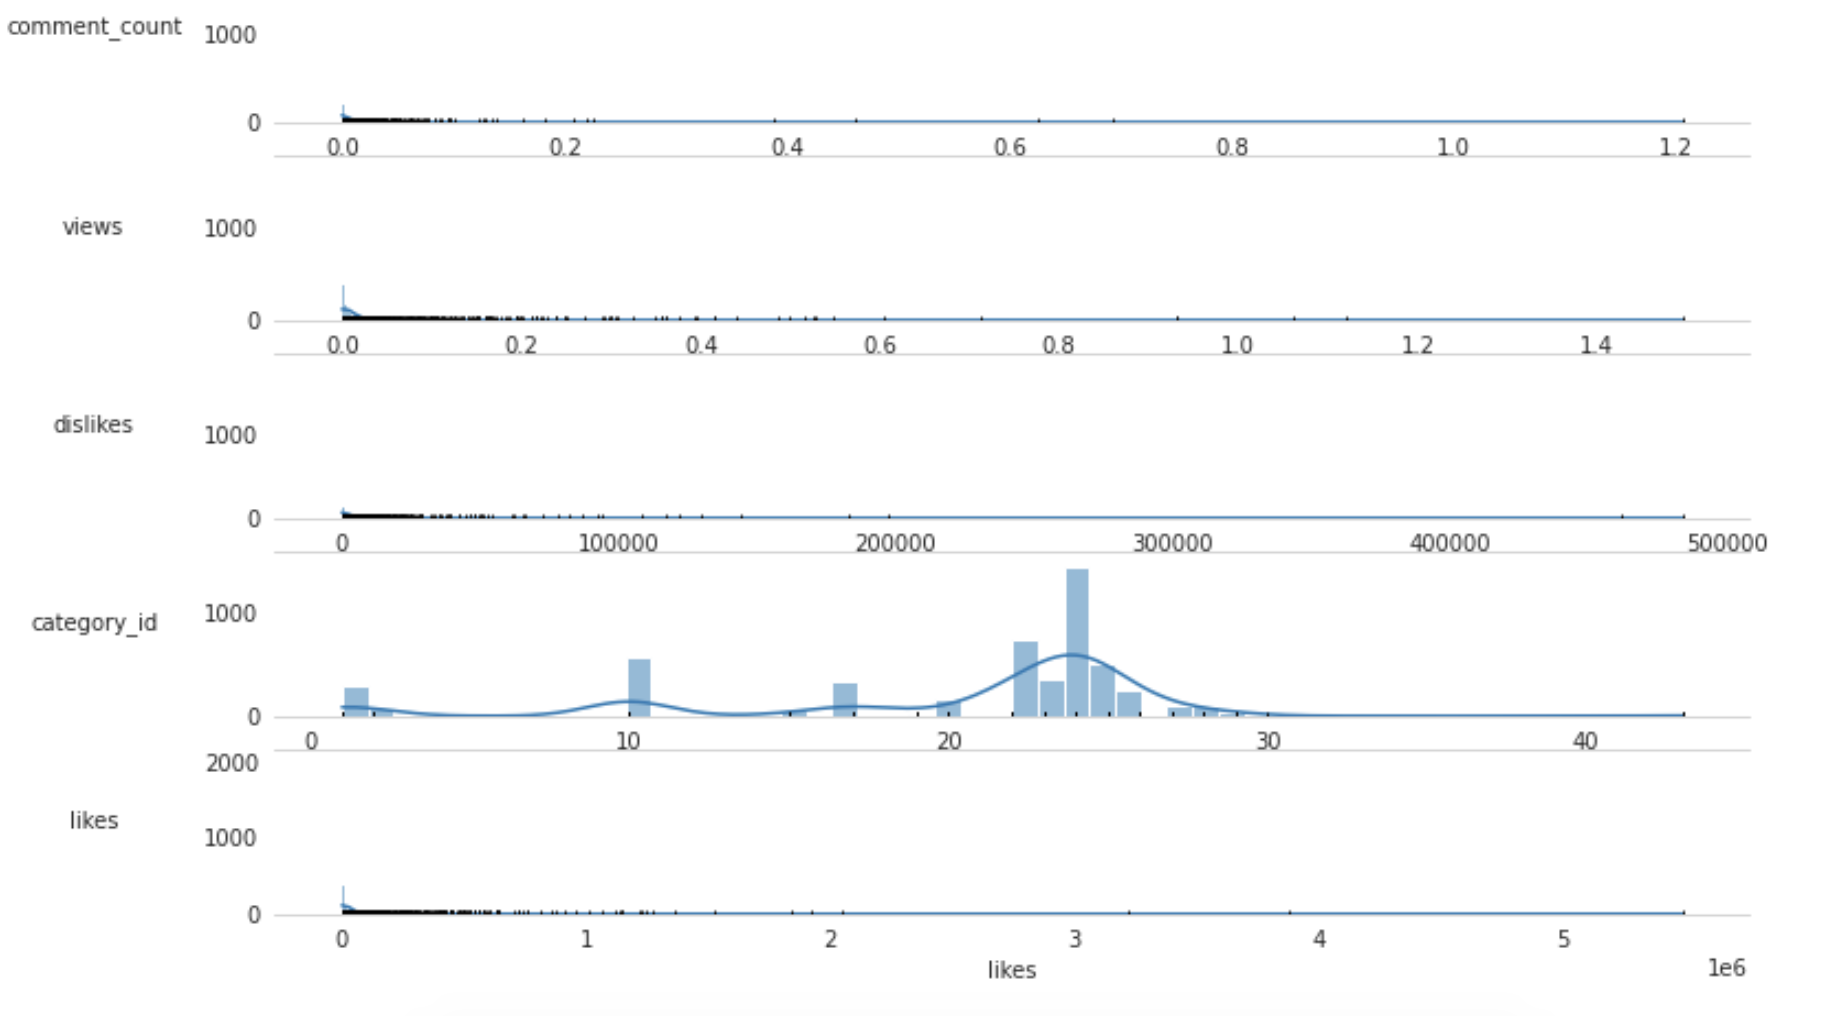

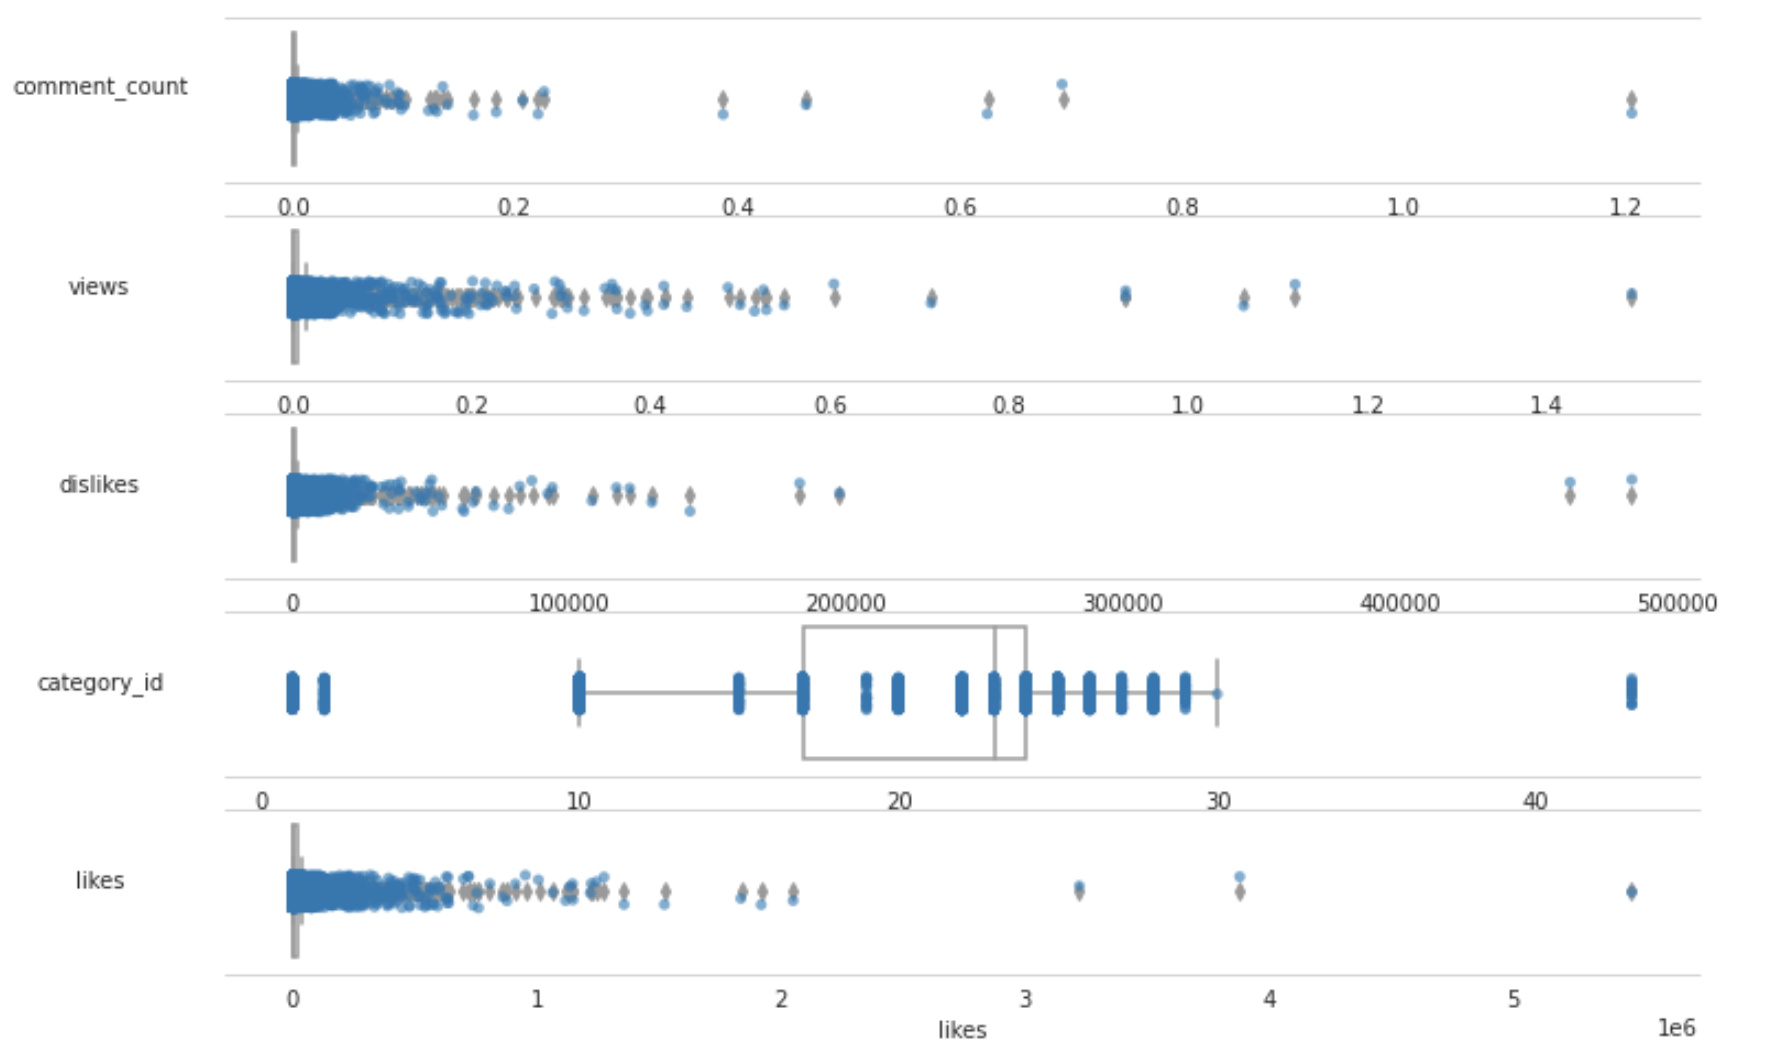

Histogram on cat cols : 

ValueError: 
Post Malone - Rockstar ft. T-Pain, Joey Bada$$ (Remix)
                                            ^
Expected end of text, found '$'  (at char 44), (line:1, col:45)

### Code

In [ ]:
if all_df.shape[0] > 5_000:
    small_df = all_df.sample(5_000)

In [ ]:
def hist_num_cols(df):
    num_cols = {col for col in df.select_dtypes(include="number")}

    custom_params = {
        "axes.spines.left": False,
        "axes.spines.right": False,
        "axes.spines.bottom": True,
        "axes.spines.top": True,
        "axes.grid": False,
    }
    with sns.axes_style("whitegrid", rc=custom_params):

        fig, axs = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(12, 8))

        for idx, col in enumerate(num_cols):
            sns.histplot(x=df[col], data=df, ax=axs[idx], kde=True)
            sns.rugplot(x=df[col], data=df, ax=axs[idx], c="black")
            axs[idx].set_ylabel(col, rotation=0, labelpad=50)
            
hist_num_cols(small_df)

In [ ]:
def box_num_cols(df):
    num_cols = {col for col in df.select_dtypes(include="number")}

    custom_params = {
        "axes.spines.left": False,
        "axes.spines.right": False,
        "axes.spines.bottom": True,
        "axes.spines.top": True,
        "axes.grid": False,
    }
    with sns.axes_style("whitegrid", rc=custom_params):

        fig, axs = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(12, 8))

        for idx, col in enumerate(num_cols):
            sns.boxplot(x=df[col], data=df, ax=axs[idx], color="white")
            sns.stripplot(x=df[col], data=df, ax=axs[idx], alpha=0.6)
            axs[idx].set_ylabel(col, rotation=0, labelpad=50)
box_num_cols(small_df)

In [ ]:
def hist_cat_cols(df):
    num_cols = {col for col in df.select_dtypes(exclude="number")}

    custom_params = {
        "axes.spines.left": False,
        "axes.spines.right": False,
        "axes.spines.bottom": True,
        "axes.spines.top": True,
        "axes.grid": False,
    }
    with sns.axes_style("whitegrid", rc=custom_params):

        fig, axs = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(12, 8))

        for idx, col in enumerate(num_cols):
            sns.histplot(x=df[col].fillna("NA"), data=df, ax=axs[idx])
            axs[idx].set_ylabel(col, rotation=0, labelpad=50)
            plt.tight_layout()

hist_cat_cols(small_df)

Input from Domain Expert:
  - Missing values
        - why are some values are missing? 
        - can they have a meaning? 
        eg NaN can be replaced by zero, observation should be imputed or discarted etc...
        
  - Any apparent issue ? 
         - e.g. missing unique values in a category
         - e.g. suspicious distributions, wrong units ...
  - Candidate columns
         - object to Categorical
         - object to bool
         - float to integer after NaN removal
         - float precision 
         - use Nullable type if it makes sense (pd.Int64, pd.Boolean)

_______________

# Data Cleaning

In [14]:
def mem_report(all_df, optimized_df):
    original_size  = all_df.memory_usage(deep=True).sum()       // 1_000_000
    optimized_size = optimized_df.memory_usage(deep=True).sum() // 1_000_000

    print(f"{original_size} MB ==> {optimized_size} MB")
    print(f"{(1 - ((optimized_size / original_size))) * 100:.2f}% saved")

## Drop duplicates & reset index

In [15]:
optimized_df = all_df.drop_duplicates().reset_index(drop=True)

In [16]:
mem_report(all_df, optimized_df)

1069 MB ==> 1034 MB
3.27% saved


## Make `country`, `category_id` columns as categorical dtype

In [17]:
optimized_df = (
    optimized_df.assign(category_id=lambda df_: pd.Categorical(df_.category_id))
                .assign(country=lambda df_: pd.Categorical(df_.country))
)
optimized_df.head().dtypes

video_id                    object
trending_date               object
title                       object
channel_title               object
category_id               category
publish_time                object
tags                        object
views                        int64
likes                        int64
dislikes                     int64
comment_count                int64
thumbnail_link              object
comments_disabled             bool
ratings_disabled              bool
video_error_or_removed        bool
description                 object
country                   category
dtype: object

In [18]:
mem_report(all_df, optimized_df)

1069 MB ==> 1010 MB
5.52% saved


## Turn into datetime `trending_date`, `publish_time`

In [19]:
optimized_df = (
    optimized_df.assign(trending_date=lambda df_: pd.to_datetime(df_.trending_date, format="%y.%d.%m"))
                .assign(publish_time= lambda df_: pd.to_datetime(df_.publish_time))
)
optimized_df.dtypes

video_id                               object
trending_date                  datetime64[ns]
title                                  object
channel_title                          object
category_id                          category
publish_time              datetime64[ns, UTC]
tags                                   object
views                                   int64
likes                                   int64
dislikes                                int64
comment_count                           int64
thumbnail_link                         object
comments_disabled                        bool
ratings_disabled                         bool
video_error_or_removed                   bool
description                            object
country                              category
dtype: object

In [20]:
mem_report(all_df, optimized_df)

1069 MB ==> 963 MB
9.92% saved


## Make `views`, `likes`, `dislikes`, `comment_count`,   as int32

### Checks : uint16 and 32 , to_numeric

In [21]:
cols = ["views", "likes", "dislikes", "comment_count"]

In [22]:
# check : np.uint16 too small
for col in cols:
    print(col,
          f"uint16 min: {np.iinfo(np.uint16).min}, max:{np.iinfo(np.uint16).max}",
          f"{col} min: {min(all_df[col])}, max:{max(all_df[col])}",
          f"min fits in  np.uint16 : {np.iinfo(np.uint16).min <= min(all_df[col]) < np.iinfo(np.uint16).max}",
          f"max fits in  np.uint16 : {np.iinfo(np.uint16).min <= max(all_df[col]) < np.iinfo(np.uint16).max}",
         sep='\n')
    print("\n")

views
uint16 min: 0, max:65535
views min: 117, max:424538912
min fits in  np.uint16 : True
max fits in  np.uint16 : False


likes
uint16 min: 0, max:65535
likes min: 0, max:5613827
min fits in  np.uint16 : True
max fits in  np.uint16 : False


dislikes
uint16 min: 0, max:65535
dislikes min: 0, max:1944971
min fits in  np.uint16 : True
max fits in  np.uint16 : False


comment_count
uint16 min: 0, max:65535
comment_count min: 0, max:1626501
min fits in  np.uint16 : True
max fits in  np.uint16 : False




In [23]:
# check : np.uint32 OK
for col in cols:
    print(col,
          f"uint32 min: {np.iinfo(np.uint32).min}, max:{np.iinfo(np.uint32).max}",
          f"{col} min: {min(all_df[col])}, max:{max(all_df[col])}",
          f"min fits in  np.uint32 : {np.iinfo(np.uint32).min <= min(all_df[col]) < np.iinfo(np.uint32).max}",
          f"max fits in  np.uint32 : {np.iinfo(np.uint32).min <= max(all_df[col]) < np.iinfo(np.uint32).max}",
         sep='\n')
    print("\n")

views
uint32 min: 0, max:4294967295
views min: 117, max:424538912
min fits in  np.uint32 : True
max fits in  np.uint32 : True


likes
uint32 min: 0, max:4294967295
likes min: 0, max:5613827
min fits in  np.uint32 : True
max fits in  np.uint32 : True


dislikes
uint32 min: 0, max:4294967295
dislikes min: 0, max:1944971
min fits in  np.uint32 : True
max fits in  np.uint32 : True


comment_count
uint32 min: 0, max:4294967295
comment_count min: 0, max:1626501
min fits in  np.uint32 : True
max fits in  np.uint32 : True




In [24]:
# check if to_numeric would downcast as e want : need to use  downcast='unsigned'
for col in cols:
    print(col)
    print("original                        :", all_df[col].memory_usage(deep=True))
    print("to_numeric                      :", pd.to_numeric(all_df[col]).memory_usage(deep=True))
    print("to_numeric  downcast='unsigned' :", pd.to_numeric(all_df[col], downcast='unsigned').memory_usage(deep=True))
    print("int32                           :", all_df[col].astype(np.int32).memory_usage(deep=True))
    print("="*80)

views
original                        : 6015072
to_numeric                      : 6015072
to_numeric  downcast='unsigned' : 4511304
int32                           : 4511304
likes
original                        : 6015072
to_numeric                      : 6015072
to_numeric  downcast='unsigned' : 4511304
int32                           : 4511304
dislikes
original                        : 6015072
to_numeric                      : 6015072
to_numeric  downcast='unsigned' : 4511304
int32                           : 4511304
comment_count
original                        : 6015072
to_numeric                      : 6015072
to_numeric  downcast='unsigned' : 4511304
int32                           : 4511304


### Transformations

In [25]:
optimized_df = (
    optimized_df.assign(views=         lambda df_: df_.views.astype(np.int32))
                .assign(likes=         lambda df_: df_.likes.astype(np.int32))
                .assign(dislikes=      lambda df_: df_.dislikes.astype(np.int32))
                .assign(comment_count= lambda df_: df_.comment_count.astype(np.int32))
)
optimized_df.dtypes

video_id                               object
trending_date                  datetime64[ns]
title                                  object
channel_title                          object
category_id                          category
publish_time              datetime64[ns, UTC]
tags                                   object
views                                   int32
likes                                   int32
dislikes                                int32
comment_count                           int32
thumbnail_link                         object
comments_disabled                        bool
ratings_disabled                         bool
video_error_or_removed                   bool
description                            object
country                              category
dtype: object

In [26]:
mem_report(all_df, optimized_df)

1069 MB ==> 957 MB
10.48% saved


## Process `video_id`

### Explore

In [27]:
optimized_df.query("video_id == '#NAME?'").shape

(2138, 17)

In [28]:
# 66 observations have the wrong video_id, not just the '#NAME?' value
# => specify video_id == '#NAME?' to change only the rows we want
(
    pd.concat(
        [
            optimized_df.thumbnail_link,
            optimized_df.video_id,
            optimized_df.thumbnail_link.str[23:]
                .str.replace("/default.jpg", "")
                .str.replace("/default_live.jpg", ""),
            optimized_df.thumbnail_link.str[23:]
                .str.replace("/default.jpg", "")
                .str.replace("/default_live.jpg", "")
            == optimized_df.video_id,
        ],
        axis="columns",
    )
    .rename(columns={0: "id_match"})
    .query("id_match==False and video_id!= '#NAME?'")
)

<ipython-input-28-54c9fb8634f6>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  optimized_df.thumbnail_link.str[23:]
<ipython-input-28-54c9fb8634f6>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  optimized_df.thumbnail_link.str[23:]


,thumbnail_link,video_id,thumbnail_link,id_match
14,https://i.ytimg.com/vi/7jmJtdqI6YE/default.jpg,Dhhp8M5K3UI,7jmJtdqI6YE,False
6084,https://i.ytimg.com/vi/sKzvcZaXMW0/default.jpg,HtdpgVqm_JU,sKzvcZaXMW0,False
6716,https://i.ytimg.com/vi/_SEQEA6eNPc/default.jpg,63uwue_AB_M,_SEQEA6eNPc,False
11003,https://i.ytimg.com/vi/fr46A-tbLuY/default.jpg,JzSQL1rZcAc,fr46A-tbLuY,False
11326,https://i.ytimg.com/vi/S84rdyr9MLI/default.jpg,JzSQL1rZcAc,S84rdyr9MLI,False
...,...,...,...,...
259600,https://i.ytimg.com/vi/AUSspdHxNt4/default.jpg,bUStcgFlAIY,AUSspdHxNt4,False
259860,https://i.ytimg.com/vi/kLawXJfmlAs/default.jpg,bUStcgFlAIY,kLawXJfmlAs,False
299225,https://i.ytimg.com/vi/-V1Oo7srGf0/default.jpg,kZete48ZtsY,-V1Oo7srGf0,False
299481,https://i.ytimg.com/vi/NzCSJrxQyQI/default.jpg,kZete48ZtsY,NzCSJrxQyQI,False


In [29]:
optimized_df.video_id

0         SbOwzAl9ZfQ
1         klOV6Xh-DnI
2         6L2ZF7Qzsbk
3         hcY52MFWMDM
4         _OXDcGPVAa4
             ...     
363367    l884wKofd54
363368    IP8k2xkhOdI
363369    Il-an3K9pjg
363370    -DRsfNObKIQ
363371    4YFo4bdMO8Q
Name: video_id, Length: 363372, dtype: object

### Transformations

In [30]:
optimized_df = optimized_df.assign(
    video_id=optimized_df.video_id.mask(
        (optimized_df.video_id == "#NAME?") | (optimized_df.video_id == "#VALUE!"),
        optimized_df.thumbnail_link.str.replace("/default.jpg", "")
            .str.replace("/default_live.jpg", "")
            .str[23:],
    )
)
optimized_df

<ipython-input-30-71733505dad9>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  optimized_df.thumbnail_link.str.replace("/default.jpg", "")


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
0,SbOwzAl9ZfQ,2017-11-14,Capítulo 12 | MasterChef 2017,MasterChef 2017,24,2017-11-13 06:06:22+00:00,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130,4182,361,1836,https://i.ytimg.com/vi/SbOwzAl9ZfQ/default.jpg,False,False,False,Disfruta la presencia del Chef Torreblanca en ...,MX
1,klOV6Xh-DnI,2017-11-14,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,22,2017-11-13 05:11:58+00:00,La Voz Mexico 7,104972,271,174,369,https://i.ytimg.com/vi/klOV6Xh-DnI/default.jpg,False,False,False,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,MX
2,6L2ZF7Qzsbk,2017-11-14,LOUIS CKAGÓ - EL PULSO DE LA REPÚBLICA,El Pulso De La República,25,2017-11-13 17:00:02+00:00,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064,10105,266,607,https://i.ytimg.com/vi/6L2ZF7Qzsbk/default.jpg,False,False,False,La canción del principio se llama “Este espíri...,MX
3,hcY52MFWMDM,2017-11-14,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,25,2017-11-13 03:47:10+00:00,"temblor|""costa rica""|""sismo en costa rica""",96153,378,171,208,https://i.ytimg.com/vi/hcY52MFWMDM/default.jpg,False,False,False,El video es de un Walmart en el pais centroame...,MX
4,_OXDcGPVAa4,2017-11-14,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,26,2017-11-13 19:17:48+00:00,"MUSAS|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965,57781,681,7428,https://i.ytimg.com/vi/_OXDcGPVAa4/default.jpg,False,False,False,MI HERMANO NARRA MI RUTINA DE MAQUILLAJE\nhttp...,MX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363367,l884wKofd54,2018-06-14,Enrique Iglesias - MOVE TO MIAMI (Official Vid...,EnriqueIglesiasVEVO,10,2018-05-09 07:00:01+00:00,"Enrique Iglesias feat. Pitbull|""MOVE TO MIAMI""...",25066952,268088,12783,9933,https://i.ytimg.com/vi/l884wKofd54/default.jpg,False,False,False,NEW SONG - MOVE TO MIAMI feat. Pitbull (Click ...,GB
363368,IP8k2xkhOdI,2018-06-14,Jacob Sartorius - Up With It (Official Music V...,Jacob Sartorius,10,2018-05-11 17:09:16+00:00,"jacob sartorius|""jacob""|""up with it""|""jacob sa...",1492219,61998,13781,24330,https://i.ytimg.com/vi/IP8k2xkhOdI/default.jpg,False,False,False,THE OFFICIAL UP WITH IT MUSIC VIDEO!Get my new...,GB
363369,Il-an3K9pjg,2018-06-14,Anne-Marie - 2002 [Official Video],Anne-Marie,10,2018-05-08 11:05:08+00:00,"anne|""marie""|""anne-marie""|""2002""|""two thousand...",29641412,394830,8892,19988,https://i.ytimg.com/vi/Il-an3K9pjg/default.jpg,False,False,False,Get 2002 by Anne-Marie HERE ▶ http://ad.gt/200...,GB
363370,-DRsfNObKIQ,2018-06-14,Eleni Foureira - Fuego - Cyprus - LIVE - First...,Eurovision Song Contest,24,2018-05-08 20:32:32+00:00,"Eurovision Song Contest|""2018""|""Lisbon""|""Cypru...",14317515,151870,45875,26766,https://i.ytimg.com/vi/-DRsfNObKIQ/default.jpg,False,False,False,Eleni Foureira represented Cyprus at the first...,GB


## Lowercase `title`, `channel_title`, `tags`, `description`

In [31]:
optimized_df = optimized_df.assign(
    title=optimized_df.title.str.lower(),
    channel_title=optimized_df.channel_title.str.lower(),
    tags=optimized_df.tags.str.lower(),
    description=optimized_df.description.str.lower()
)

In [32]:
optimized_df.sample(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
329267,Bhg9I26EghQ,2017-12-07,what i've been up to (an emotional video diary...,lily pebbles,26,2017-12-03 09:30:00+00:00,"lily|""lilypebbles""|""pebbles""|""book""|""author""|""...",108331,4373,264,409,https://i.ytimg.com/vi/Bhg9I26EghQ/default.jpg,False,False,False,so... now the secret is out i can share my jou...,GB
311875,5mar5AHglGI,2018-04-05,these things happened (artist spotlight story)...,g-eazy,24,2018-03-20 15:59:58+00:00,"g-eazy|""g-eazy 2017""|""g eazy 2017""|""g eazy""|""w...",431137,26604,400,1523,https://i.ytimg.com/vi/5mar5AHglGI/default.jpg,False,False,False,"produced by youtube, these things happened chr...",US
245715,wbNpGbL8j_w,2017-11-27,les terriens s'écharpent sur manuel valls,gaetano gitano,22,2017-11-26 22:05:32+00:00,[none],5566,16,6,40,https://i.ytimg.com/vi/wbNpGbL8j_w/default.jpg,False,False,False,NaN,FR
81346,JS-oQyQhiUU,2017-12-23,michael wolffsohn über den judenhass-import-we...,achgut.pogo,25,2017-12-22 14:16:48+00:00,"michael wolffsohn|""angela merkel""|""sigmar gabr...",8728,383,14,69,https://i.ytimg.com/vi/JS-oQyQhiUU/default.jpg,False,False,False,mit dem historiker und publizisten professor m...,DE
314388,6tgptWcKkgc,2018-04-24,we tried the zero waste lifestyle for a week 🗑️♻️,michelle khare,24,2018-04-16 19:32:09+00:00,"zero waste|""zero waste living""|""michelle khare...",133773,7202,82,568,https://i.ytimg.com/vi/6tgptWcKkgc/default.jpg,False,False,False,"after your many requests, i finally decided to...",US


## Enrich with `category`

In [217]:
def get_youtube_categories():
    
    source_url ="https://gist.githubusercontent.com/dgp/1b24bf2961521bd75d6c/raw/9abca29c436218972e6e28de7c03060845ed85d9/youtube%2520api%2520video%2520category%2520id%2520list"
    
    return (
    pd.read_csv(source_url, header=None, names=["category_id"])
        .category_id.str.split(" - ", expand=True)
        .rename(columns={0: "category_id", 1: "category"})
        .loc[:31]
        .assign(category_id= lambda df_: df_.category_id.astype("int64"))
        .assign(category_id= lambda df_: df_.category_id.astype("category"))
        .assign(category= lambda df_: df_.category.str.strip())
)

In [219]:
categories_df = get_youtube_categories()
categories_df

,category_id,category
0,2,Autos & Vehicles
1,1,Film & Animation
2,10,Music
3,15,Pets & Animals
4,17,Sports
5,18,Short Movies
6,19,Travel & Events
7,20,Gaming
8,21,Videoblogging
9,22,People & Blogs


In [216]:
optimized_df = (
    optimized_df.merge(get_youtube_categories(), 
                       how='left', 
                       left_on='category_id', 
                       right_on='category_id')
)

optimized_df.sample(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category_x,category_y
61059,8uxf80ma1SM,2018-03-11,rourkela lady marries another man while husban...,kanak news,25,2018-03-08 15:18:39+00:00,"odisha news|""odisha latest news""|""odisha lates...",230311,1279,104,214,https://i.ytimg.com/vi/8uxf80ma1SM/default.jpg,False,False,False,for latest odisha news follow us:\nvisit: http...,IN,News & Politics,News & Politics
114137,Q3L0gArhmaE,2018-06-14,someone stop this madman!,pewdiepie,24,2018-06-12 18:30:01+00:00,"satire|""flex seal""|""flex spray""|""flex commerci...",3893338,289795,8865,32839,https://i.ytimg.com/vi/Q3L0gArhmaE/default.jpg,False,False,False,we review the classic flex seal meme and the n...,DE,Entertainment,Entertainment
259529,ZVXRilivcDo,2018-02-06,戀愛先生 | mr right 41【dvd版】（靳東、江疏影、李乃文、李宗翰等主演）,大劇獨播,1,2018-02-05 16:00:02+00:00,"電視劇""|""大陸電視劇""|""恋爱先生""|""mr right""|""都市""|""情感""|""靳东""|...",171396,124,52,144,https://i.ytimg.com/vi/ZVXRilivcDo/default.jpg,False,False,False,thanks for watching the drama! help more peopl...,FR,Film & Animation,Film & Animation
52288,-9MAylsrai4,2018-01-18,அலங்காநல்லூர் ஜல்லிக்கட்டு 01 | alanganallur j...,news7 tamil,25,2018-01-16 12:48:59+00:00,"news 7 tamil|""news 7 news""|""tamil news""|""news7...",122079,762,54,12,https://i.ytimg.com/vi/-9MAylsrai4/default.jpg,False,False,False,அலங்காநல்லூர் ஜல்லிக்கட்டு 01 | alanganallur j...,IN,News & Politics,News & Politics
130083,8R8GVxopH5M,2017-11-19,아기부터 챙긴 산후조리원 직원들 / sbs,sbs 뉴스,25,2017-11-18 12:48:37+00:00,"뉴스|""news""|""news""|""sbs""|""sbs""|""sbs news""|""sbs8n...",200290,3394,47,1281,https://i.ytimg.com/vi/8R8GVxopH5M/default.jpg,False,False,False,지진이 난 긴박한 순간에도 아기들의 안전을 먼저 챙긴 산후조리원 직원들이 있습니다....,KR,News & Politics,News & Politics


## Process `tags`

In [47]:
del all_df

NameError: name 'all_df' is not defined

In [43]:
""" #clean list of tags #not useful
tags_s = (
    optimized_df.tags.str.split("|")
                     .explode("tags")
                     .str.replace("\"", "")
                     .str.split()
                     .explode("tags")
)
tags_s"""

#del tags_s

0           masterchef
1               junior
2                 2017
3                   tv
4               azteca
               ...    
11538547         coast
11538548           hip
11538549           hop
11538550         super
11538551         duper
Name: tags, Length: 11538552, dtype: object

In [121]:
vec_list = [CountVectorizer().fit_transform(df.tags) for df in df_list]
vec_shapes = [vec.shape for vec in vec_list]

In [124]:
vec_dict= {k:v for k, v in zip(df_countries, vec_list)}
vec_shapes_dict= {k:v for k, v in zip(df_countries, vec_shapes)}

In [125]:
vec_dict

{'MX': <40451x48659 sparse matrix of type '<class 'numpy.int64'>'
 	with 764801 stored elements in Compressed Sparse Row format>,
 'IN': <37352x31067 sparse matrix of type '<class 'numpy.int64'>'
 	with 866364 stored elements in Compressed Sparse Row format>,
 'DE': <40840x81893 sparse matrix of type '<class 'numpy.int64'>'
 	with 882914 stored elements in Compressed Sparse Row format>,
 'JP': <20523x43229 sparse matrix of type '<class 'numpy.int64'>'
 	with 288622 stored elements in Compressed Sparse Row format>,
 'KR': <34567x50847 sparse matrix of type '<class 'numpy.int64'>'
 	with 578395 stored elements in Compressed Sparse Row format>,
 'CA': <40881x55864 sparse matrix of type '<class 'numpy.int64'>'
 	with 944619 stored elements in Compressed Sparse Row format>,
 'RU': <40739x79804 sparse matrix of type '<class 'numpy.int64'>'
 	with 853800 stored elements in Compressed Sparse Row format>,
 'FR': <40724x60865 sparse matrix of type '<class 'numpy.int64'>'
 	with 744757 stored ele

In [143]:
vec_shapes_dict.items()

dict_items([('MX', (40451, 48659)), ('IN', (37352, 31067)), ('DE', (40840, 81893)), ('JP', (20523, 43229)), ('KR', (34567, 50847)), ('CA', (40881, 55864)), ('RU', (40739, 79804)), ('FR', (40724, 60865)), ('US', (40949, 23483)), ('GB', (38916, 16057))])

## Next

In [36]:
optimized_df.dtypes

video_id                               object
trending_date                  datetime64[ns]
title                                  object
channel_title                          object
category_id                          category
publish_time              datetime64[ns, UTC]
tags                                   object
views                                   int32
likes                                   int32
dislikes                                int32
comment_count                           int32
thumbnail_link                         object
comments_disabled                        bool
ratings_disabled                         bool
video_error_or_removed                   bool
description                            object
country                              category
dtype: object

In [37]:
optimized_df

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
0,SbOwzAl9ZfQ,2017-11-14,capítulo 12 | masterchef 2017,masterchef 2017,24,2017-11-13 06:06:22+00:00,"masterchef junior 2017|""tv azteca""|""recetas""|""...",310130,4182,361,1836,https://i.ytimg.com/vi/SbOwzAl9ZfQ/default.jpg,False,False,False,disfruta la presencia del chef torreblanca en ...,MX
1,klOV6Xh-DnI,2017-11-14,alexa ex-integrante del grupo timbiriche renun...,micky contreras martinez,22,2017-11-13 05:11:58+00:00,la voz mexico 7,104972,271,174,369,https://i.ytimg.com/vi/klOV6Xh-DnI/default.jpg,False,False,False,alexa ex-integrante del grupo timbiriche renun...,MX
2,6L2ZF7Qzsbk,2017-11-14,louis ckagó - el pulso de la república,el pulso de la república,25,2017-11-13 17:00:02+00:00,"chumel torres|""el pulso de la republica""|""noti...",136064,10105,266,607,https://i.ytimg.com/vi/6L2ZF7Qzsbk/default.jpg,False,False,False,la canción del principio se llama “este espíri...,MX
3,hcY52MFWMDM,2017-11-14,sismo de 6.7 sacude costa rica 12 noviembre 2017,casanare,25,2017-11-13 03:47:10+00:00,"temblor|""costa rica""|""sismo en costa rica""",96153,378,171,208,https://i.ytimg.com/vi/hcY52MFWMDM/default.jpg,False,False,False,el video es de un walmart en el pais centroame...,MX
4,_OXDcGPVAa4,2017-11-14,dog hacks | musas lesslie los polinesios,musas,26,2017-11-13 19:17:48+00:00,"musas|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965,57781,681,7428,https://i.ytimg.com/vi/_OXDcGPVAa4/default.jpg,False,False,False,mi hermano narra mi rutina de maquillaje\nhttp...,MX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363367,l884wKofd54,2018-06-14,enrique iglesias - move to miami (official vid...,enriqueiglesiasvevo,10,2018-05-09 07:00:01+00:00,"enrique iglesias feat. pitbull|""move to miami""...",25066952,268088,12783,9933,https://i.ytimg.com/vi/l884wKofd54/default.jpg,False,False,False,new song - move to miami feat. pitbull (click ...,GB
363368,IP8k2xkhOdI,2018-06-14,jacob sartorius - up with it (official music v...,jacob sartorius,10,2018-05-11 17:09:16+00:00,"jacob sartorius|""jacob""|""up with it""|""jacob sa...",1492219,61998,13781,24330,https://i.ytimg.com/vi/IP8k2xkhOdI/default.jpg,False,False,False,the official up with it music video!get my new...,GB
363369,Il-an3K9pjg,2018-06-14,anne-marie - 2002 [official video],anne-marie,10,2018-05-08 11:05:08+00:00,"anne|""marie""|""anne-marie""|""2002""|""two thousand...",29641412,394830,8892,19988,https://i.ytimg.com/vi/Il-an3K9pjg/default.jpg,False,False,False,get 2002 by anne-marie here ▶ http://ad.gt/200...,GB
363370,-DRsfNObKIQ,2018-06-14,eleni foureira - fuego - cyprus - live - first...,eurovision song contest,24,2018-05-08 20:32:32+00:00,"eurovision song contest|""2018""|""lisbon""|""cypru...",14317515,151870,45875,26766,https://i.ytimg.com/vi/-DRsfNObKIQ/default.jpg,False,False,False,eleni foureira represented cyprus at the first...,GB


In [38]:
optimized_df.loc[38914]

video_id                                                        W7nE_zGVUFg
trending_date                                           2018-06-06 00:00:00
title                     todo los movimientos en el draft miguel herrer...
channel_title                                                     elpapas99
category_id                                                              17
publish_time                                      2018-06-05 03:35:31+00:00
tags                                                                 [none]
views                                                                151124
likes                                                                   613
dislikes                                                                 84
comment_count                                                           154
thumbnail_link               https://i.ytimg.com/vi/W7nE_zGVUFg/default.jpg
comments_disabled                                                     False
ratings_disa

In [ ]:
all_df.drop_duplicates().shape

In [ ]:
# do we have the same shapes for each col vs original dataset ?
# Goal: find a good key for the index
for col in optimized_df.columns:
    print(col, optimized_df[col].shape == all_df.drop_duplicates().shape)

In [ ]:
mask=(optimized_df.trending_date.astype(str) + optimized_df.video_id.astype(str)).duplicated()
optimized_df[mask]

## Data Cleaning Consolidation

In [220]:
def clean_df(df):
    return (df.assign(category_id=  lambda df_: pd.Categorical(df_.category_id))
              .assign(country=      lambda df_: pd.Categorical(df_.country))
              .assign(trending_date=lambda df_: pd.to_datetime(df_.trending_date, format="%y.%d.%m"))
              .assign(publish_time= lambda df_: pd.to_datetime(df_.publish_time))
              .assign(views=        lambda df_: df_.views.astype(np.int32))
              .assign(likes=        lambda df_: df_.likes.astype(np.int32))
              .assign(dislikes=     lambda df_: df_.dislikes.astype(np.int32))
              .assign(comment_count=lambda df_: df_.comment_count.astype(np.int32))
              .assign(video_id=optimized_df.video_id.mask(
                        (optimized_df.video_id == "#NAME?") | (optimized_df.video_id == "#VALUE!"),
                         optimized_df.thumbnail_link.str.replace("/default.jpg", "")
                                                    .str.replace("/default_live.jpg", "")
                                                    .str[23:])
                     )
              .assign(title=optimized_df.title.str.lower(),
                      channel_title=optimized_df.channel_title.str.lower(),
                      tags=optimized_df.tags.str.lower(),
                      description=optimized_df.description.str.lower())
              .merge(get_youtube_categories(), 
                      how='left', 
                      left_on='category_id', 
                      right_on='category_id')
)
clean_df(all_df)

NameError: name 'all_df' is not defined